<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/05_vanishing_and_exploding_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Vanishing and Exploding Gradients

The gradients, together
with the learning rate, are what makes the model tick, or better yet, learn.
We always
assumed that the gradients were well behaved, as long as our learning rate was
sensible. 

Unfortunately, this is not necessarily true, and sometimes the gradients
may go awry: They can either vanish or explode. Either way, we need to rein them
in, so let’s see how we can accomplish that.

Backpropagation works fine for
models with a few hidden layers, but as models grow deeper, the gradients
computed for the weights in the initial layers become smaller and smaller. That’s
the so-called vanishing gradients problem, and it has always been a major obstacle
for training deeper models.

If gradients vanish—that is, if they are close to zero—updating the weights will
barely change them. In other words, the model is not learning anything; it gets
stuck.

Why does it happen?



##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapterextra()
# This is needed to render the plots in this chapter
from plots.chapterextra import *

Finished!


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_regression

from torch.utils.data import DataLoader, TensorDataset
from stepbystep.v3 import StepByStep

from data_generation.ball import load_data

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Ball Dataset

Let’s use a dataset of 1,000 random points drawn from a ten-dimensional ball such that each feature has zero mean and unit standard
deviation. 

In this dataset, points situated within half of the radius of the ball are
labeled as negative cases, while the remaining points are labeled positive cases.

In [4]:
X, y = load_data(n_points=1000, n_dims=10)

In [5]:
ball_dataset = TensorDataset(torch.as_tensor(X).float(), torch.as_tensor(y).float())
ball_loader = DataLoader(ball_dataset, batch_size=len(X))

##Block Model

To illustrate the vanishing gradients problem, we need a deeper model.

Let’s call it the "block" model: It is a block of several hidden
layers (and activation functions) stacked together, every layer containing the same
number of hidden units (neurons).

In [6]:
torch.manual_seed(11)

n_layers = 5
n_features = X.shape[1]
hidden_units = 100
activation_fn = nn.ReLU

model = build_model(n_features, n_layers, hidden_units, activation_fn, use_bn=False)

In [7]:
print(model)

Sequential(
  (h1): Linear(in_features=10, out_features=100, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=100, out_features=100, bias=True)
  (a2): ReLU()
  (h3): Linear(in_features=100, out_features=100, bias=True)
  (a3): ReLU()
  (h4): Linear(in_features=100, out_features=100, bias=True)
  (a4): ReLU()
  (h5): Linear(in_features=100, out_features=100, bias=True)
  (a5): ReLU()
  (o): Linear(in_features=100, out_features=1, bias=True)
)


In [8]:
# We’re only missing a loss function and an optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

##Weights, Activations, and Gradients

To visualize what’s happening with the weights, the activation values, and the
gradients, we need to capture these values first.

In [9]:
hidden_layers = [f"h{i}" for i in range(1, n_layers + 1)]
activation_layers = [f"a{i}" for i in range(1, n_layers + 1)]

In [10]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(ball_loader)

sbs.capture_parameters(hidden_layers)
sbs.capture_gradients(hidden_layers)
sbs.attach_hooks(activation_layers)

sbs.train(1)

Let’s see what the model can accomplish after training for a single epoch.

In [11]:
parms, gradients, activations = get_plot_data(train_loader=ball_loader, model=model)

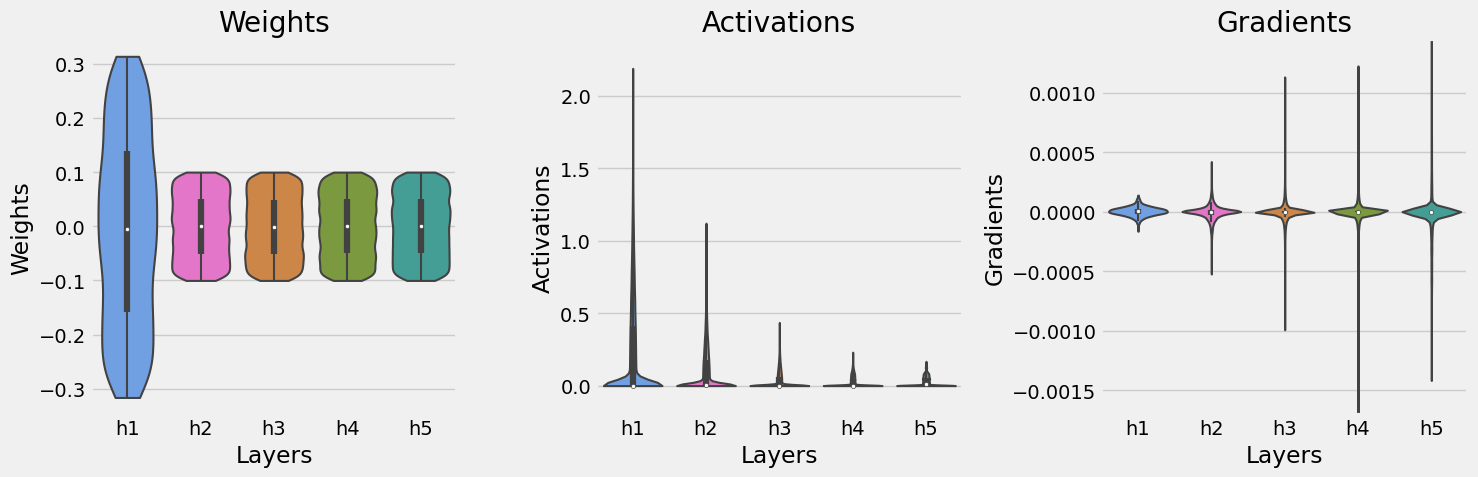

In [12]:
fig = plot_violins(parms, gradients, activations)

We can see that the initial weights in each layer are uniformly
distributed, but the first hidden layer has a much wider range. This is a
consequence of the default initialization scheme used by PyTorch’s linear layer.

The activation values are clearly shrinking as data moves from one layer to the
next. Conversely, the gradients are larger in the last layer, and shrink as the
gradient descent algorithm works its way back to the first layer. That’s a simple and
straightforward example of vanishing gradients.

How can we prevent the vanishing gradients problem?

If we manage to get the distribution of activation values similar across all layers,
we may have a shot at it. But, to achieve that, we need to tweak the variance of the weights. 

If done properly, the initial distribution of the weights may lead to a more
consistent distribution of activation values across layers.

**So, keeping similar distributions of
activation values across all layers is exactly what batch
normalization was doing.**

So, if you’re using batch normalization, vanishing gradients are likely not an issue.





##Weights Initialization Schemes

An initialization scheme is a clever way of tweaking the initial distribution of the
weights. It is all about choosing the best standard deviation to use for drawing
random weights from a normal or uniform distribution.

Kaiming
or He initialization, depending on the context. In PyTorch, it is available as both
`nn.init.kaiming_uniform()` and `nn.init.kaiming_normal()`.

Should I use uniform or normal distribution?

It shouldn’t make much of a difference, but using the uniform distribution usually
delivers slightly better results than the alternative.

If you’re using transfer learning, for instance, this is pretty
much not an issue because most of the model would be already trained, and a bad
initialization of the trainable part should have little to no impact on model training.

Besides, using batch normalization layers makes your
model much more forgiving when it comes to a bad initialization of the weights.

Each PyTorch layer has its own default initialization of the
weights in the `reset_parameters()` method.

In [13]:
def reset_parameters(self):
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))
  if self.bias is not None:
    fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)

Let’s go over a simple example. Let’s say you’d like to initialize all linear layers using
the Kaiming uniform scheme with the proper nonlinearity function for the weights
and setting all the biases to zeros.

In [14]:
def weights_init(m):
  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
    if m.bias is not None:
      nn.init.zeros_(m.bias)

In [15]:
with torch.no_grad():
  # apply the initialization scheme to your model
  model.apply(weights_init)

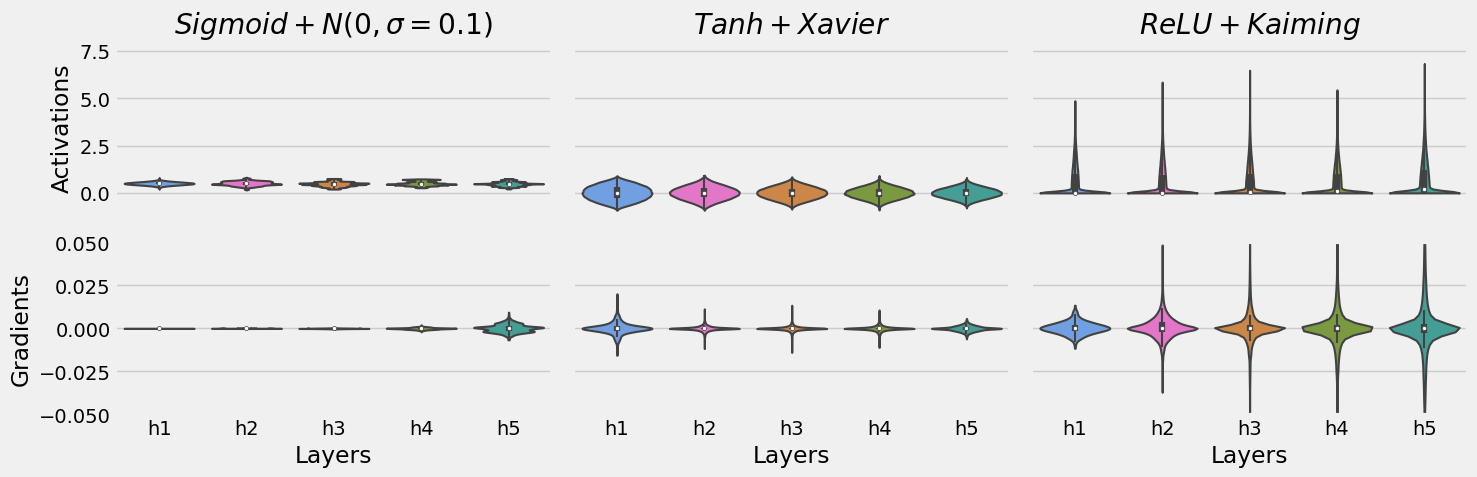

In [16]:
fig = plot_schemes(n_features, n_layers, hidden_units, ball_loader)

Well, using a sigmoid function as an activation function in deep models is just
hopeless. 

But, for the other two, it should be clear that the correct initialization of
the weights resulted in more-stable distributions of activation values and
gradients across all the layers.

Even though initialization schemes are definitely a clever approach to the vanishing
gradients problem, their usefulness vanishes, when batch
normalization layers are added to the model.

##Batch Normalization